[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Wp-Zhang/HandyRec/blob/master/examples/YouTubeDNN.ipynb)

> This notebook runs YouTubeDNN including candidate generation and ranking on MovieLens1M dataset. 

> Only movies with ratings larger than 3 are treated as 'positive' samples for each user. Every last 10 'positive' movies of each user are held out for testing.

## Table of Contents:
* [Prepare data for matching](#section-0)
* [Train match model and export embeddings](#section-1)
* [Use Faiss to generate candidates](#section-2)
* [Train rank model and predict](#section-3)

**Download dataset and install packages**

In [ ]:
! git clone https://github.com/Wp-Zhang/HandyRec.git
! pip install faiss-cpu

Cloning into 'HandyRec'...
remote: Enumerating objects: 1098, done.
remote: Counting objects: 100% (1098/1098), done.
remote: Compressing objects: 100% (846/846), done.
remote: Total 1098 (delta 395), reused 838 (delta 205), pack-reused 0
Receiving objects: 100% (1098/1098), 16.43 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (395/395), done.
     |████████████████████████████████| 8.6 MB 6.9 MB/s 


In [ ]:
! wget https://files.grouplens.org/datasets/movielens/ml-1m.zip -O ./ml-1m.zip
! unzip -o ml-1m.zip

--2022-03-31 02:21:33--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘./ml-1m.zip’

./ml-1m.zip         100%[===================>]   5.64M  13.8MB/s    in 0.4s    

2022-03-31 02:21:34 (13.8 MB/s) - ‘./ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


**Import relative packages**

In [ ]:
import sys
sys.path.append('./HandyRec/')

In [ ]:
from handyrec.dataset.movielens import MovieMatchDataHelper, MovieRankDataHelper
from handyrec.layers.utils import sampledsoftmaxloss
from handyrec.models.match import YouTubeMatchDNN
from handyrec.models.rank import YouTubeRankDNN
from handyrec.features import DenseFeature, SparseFeature, SparseSeqFeature, FeatureGroup, EmbdFeatureGroup, FeaturePool
from handyrec.dataset.metrics import map_at_k, recall_at_k
from handyrec.models.utils import search_embedding

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import gc

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MATCH_EMBEDDING_DIM = 128
RANK_EMBEDDING_DIM = 128
SEQ_LEN = 40
BATCH_SIZE = 2**12
NEPOCH = 50

NEG_NUM = 10
CANDIDATE_NUM = 100

# 0. Prepare data for matching<a name="section-0"></a>

In [ ]:
match_dh = MovieMatchDataHelper('./ml-1m/')
data = match_dh.get_clean_data(sparse_features=['gender','age','occupation','zip','year'])

match_user_features = ['user_id','gender','age','occupation','zip']
match_movie_features = [f for f in data['item'].columns if f != 'title']
match_dh.gen_dataset(match_user_features+match_movie_features, data, seq_max_len=SEQ_LEN, negnum=0)

100%|██████████| 2/2 [00:01<00:00,  1.87it/s]


In [ ]:
match_train, match_train_label, match_test, match_test_label = match_dh.load_dataset(match_user_features, match_movie_features)

Load movie Features: 100%|██████████| 3/3 [00:00<00:00, 165.87it/s]


In [ ]:
match_feature_dim = match_dh.get_feature_dim(data, match_user_features, match_movie_features, [])

# 1. Train match model and export embeddings <a name="section-1"></a>

In [ ]:
# * add example_age^2 as showed in the original paper
match_train['example_age_2'] = match_train['example_age']**2
match_test['example_age_2'] = match_test['example_age']**2

In [ ]:
match_user_dense_feats = ['example_age','example_age_2']
match_user_sparse_feats = ['user_id','gender','age','occupation','zip']

In [ ]:
match_item_dense_feats = []
match_item_sparse_feats = [f for f in match_movie_features if f!='genres']
all_item_model_input = {f:np.array(data['item'][f].tolist()) for f in match_movie_features}

In [ ]:
feat_pool1 = FeaturePool()

In [ ]:
match_item_features = [DenseFeature(x) for x in match_item_dense_feats] +\
                [SparseFeature(x, match_feature_dim[x], MATCH_EMBEDDING_DIM) for x in match_item_sparse_feats] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, MATCH_EMBEDDING_DIM), 'genres',6)]
item_feature_group = EmbdFeatureGroup(
    name='item', 
    id_name='movie_id', 
    features=match_item_features, 
    feature_pool=feat_pool1, 
    value_dict=all_item_model_input,
    embd_dim=MATCH_EMBEDDING_DIM
)

In [ ]:
match_user_features = [DenseFeature(x) for x in match_user_dense_feats] +\
                [SparseFeature(x, match_feature_dim[x], MATCH_EMBEDDING_DIM) for x in match_user_sparse_feats] +\
                [SparseSeqFeature(item_feature_group, 'hist_movie_id',SEQ_LEN)]
user_feature_group = FeatureGroup('user', match_user_features, feat_pool1)

In [ ]:
match_model = YouTubeMatchDNN(
    user_feature_group, item_feature_group,
    dnn_hidden_units=(512,256,MATCH_EMBEDDING_DIM), 
    dnn_dropout=0.1,
    dnn_bn=True,
    num_sampled=100
)

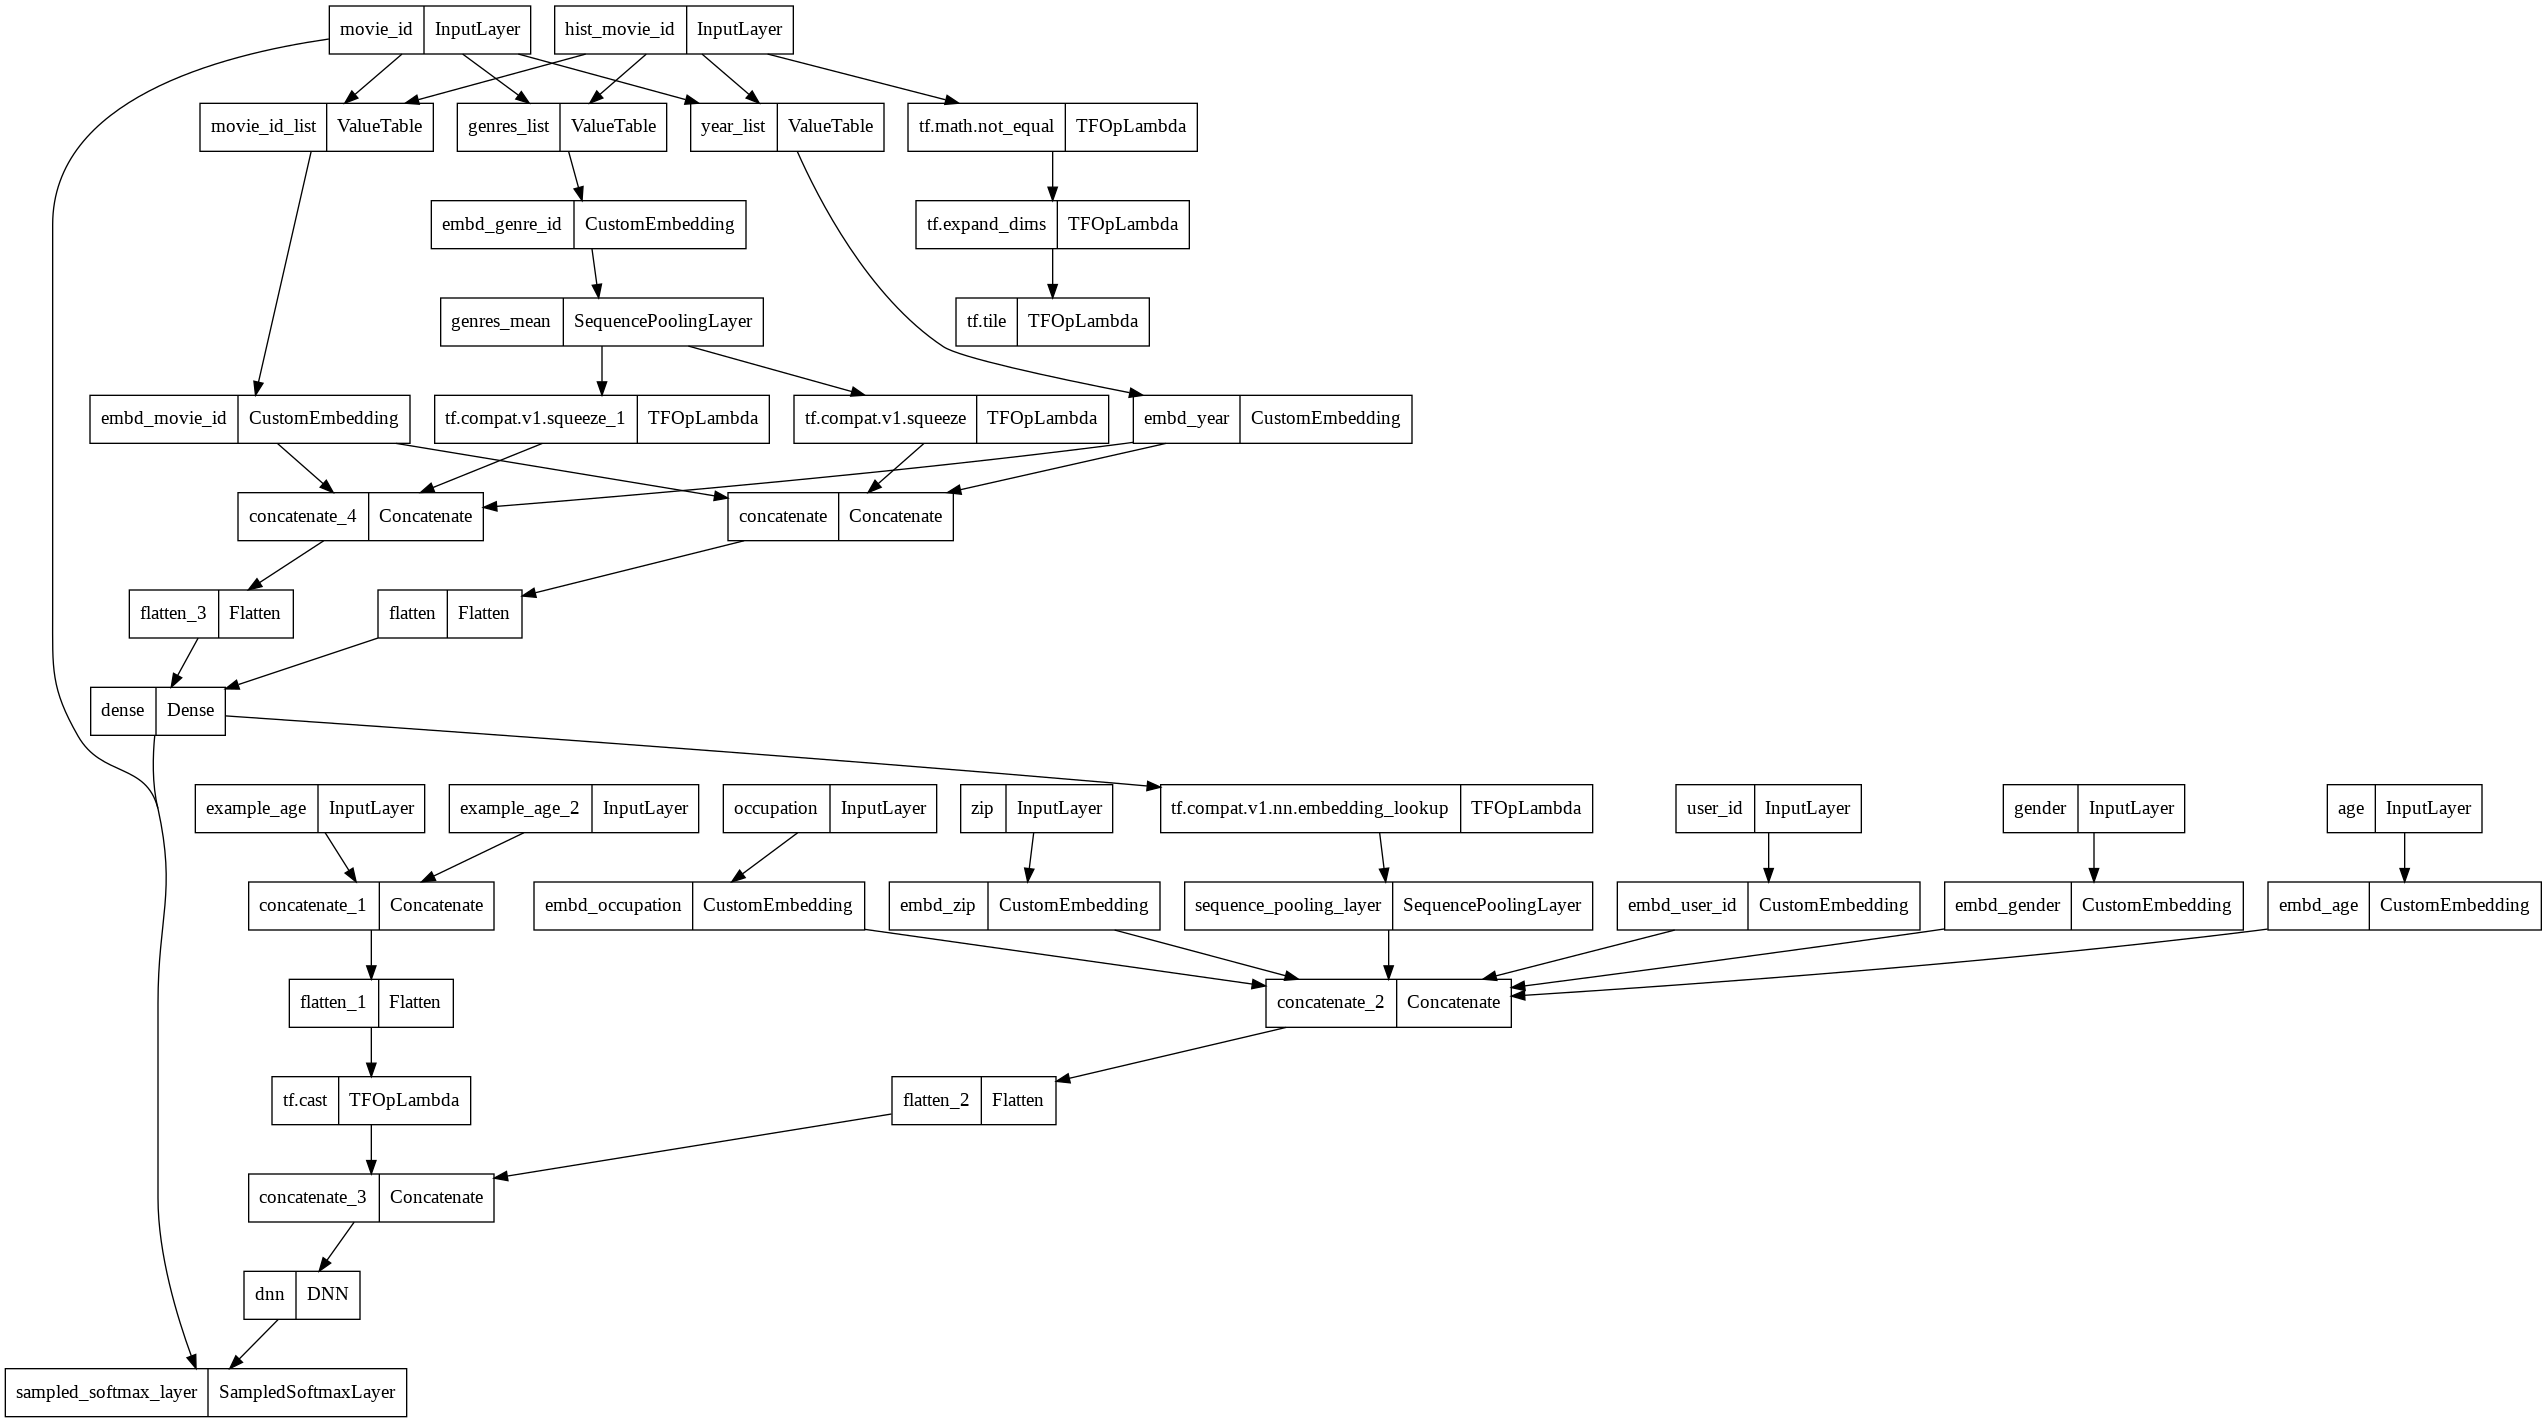

In [ ]:
plot_model(match_model)

In [ ]:
match_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=sampledsoftmaxloss)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./match_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = match_model.fit(match_train, match_train_label,
                            batch_size=BATCH_SIZE, 
                            epochs=150,
                            verbose=1,
                            validation_split=0.1,
                            callbacks=[early_stop,checkpoint])

Epoch 1/150
207/207 [==============================] - 12s 34ms/step - loss: 3.9388 - val_loss: 3.9348
Epoch 2/150
207/207 [==============================] - 6s 30ms/step - loss: 3.6487 - val_loss: 3.6175
Epoch 3/150
207/207 [==============================] - 6s 30ms/step - loss: 3.3610 - val_loss: 3.2740
Epoch 4/150
207/207 [==============================] - 6s 30ms/step - loss: 3.1743 - val_loss: 3.1161
Epoch 5/150
207/207 [==============================] - 6s 30ms/step - loss: 3.0146 - val_loss: 2.8910
Epoch 6/150
207/207 [==============================] - 6s 30ms/step - loss: 2.8635 - val_loss: 2.8128
Epoch 7/150
207/207 [==============================] - 6s 30ms/step - loss: 2.7846 - val_loss: 2.7629
Epoch 8/150
207/207 [==============================] - 6s 30ms/step - loss: 2.6959 - val_loss: 2.6735
Epoch 9/150
207/207 [==============================] - 6s 30ms/step - loss: 2.6158 - val_loss: 2.5445
Epoch 10/150
207/207 [==============================] - 6s 30ms/step - loss: 2.54

In [ ]:
match_model.load_weights('./match_checkpoint/')

In [ ]:
user_embedding_model = Model(inputs=match_model.user_input, outputs=match_model.user_embedding)
item_embedding_model = Model(inputs=match_model.item_input, outputs=match_model.item_embedding)

user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 15)

print(user_embs.shape)
print(item_embs.shape)

(6040, 128)
(3883, 128)


# 2. Use Faiss to generate candidates <a name="section-2"></a>

## Test match model

In [ ]:
candidates = search_embedding(
    MATCH_EMBEDDING_DIM, 
    item_embs, 
    user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

In [ ]:
map_at_k(match_test_label, candidates, k=10)

0.03025595895090928

In [ ]:
recall_at_k(match_test_label, candidates, k=10)

0.07619205298013246

In [ ]:
recall_at_k(match_test_label, candidates, k=100)

0.4115728476821192

## Prepare data for ranking

In [ ]:
test_user_embs = user_embedding_model.predict(match_test, batch_size=2 ** 15)
test_candidates = search_embedding(
    MATCH_EMBEDDING_DIM, 
    item_embs, 
    test_user_embs,
    data['item']['movie_id'].values,
    CANDIDATE_NUM)

test_candidates = {
    match_test['user_id'][i] : test_candidates[i]
    for i in range(test_candidates.shape[0])
}

In [ ]:
del user_embs, item_embs, match_train, match_train_label, test_user_embs
gc.collect()

3024

In [ ]:
rank_dh = MovieRankDataHelper('./ml-1m/')
rank_user_features = ['user_id','gender','age','occupation','zip']
rank_movie_features = [f for f in data['item'].columns if f != 'title']

rank_dh.gen_dataset(rank_user_features+rank_movie_features, data, test_candidates, seq_max_len=SEQ_LEN, negnum=NEG_NUM)

100%|██████████| 2/2 [00:10<00:00,  5.46s/it]


In [ ]:
rank_train, rank_train_label, rank_test = rank_dh.load_dataset(rank_user_features, rank_movie_features)

Load movie Features: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [ ]:
rank_train['example_age_2'] = rank_train['example_age']**2
rank_test['example_age_2'] = rank_test['example_age']**2
rank_train['time_gap_2'] = rank_train['time_gap']**2
rank_train['time_gap_square'] = np.sqrt(rank_train['time_gap'])
rank_test['time_gap_2'] = rank_test['time_gap']**2
rank_test['time_gap_square'] = np.sqrt(rank_test['time_gap'])

In [ ]:
rank_feature_dim = rank_dh.get_feature_dim(data, rank_user_features, rank_movie_features, [])

# 3. Train rank model and predict <a name="section-3"></a>

In [ ]:
rank_user_dense_feats = ['time_gap','time_gap_2','time_gap_square','example_age','example_age_2']
rank_user_sparse_feats = ['user_id','gender','age','occupation', 'zip']
rank_item_dense_feats = []
rank_item_sparse_feats = [f for f in rank_movie_features if f!='genres']

In [ ]:
feat_pool2 = FeaturePool()

In [ ]:
rank_user_features = [SparseFeature(x, rank_feature_dim[x], RANK_EMBEDDING_DIM) for x in rank_user_sparse_feats] +\
                [DenseFeature(x) for x in rank_user_dense_feats] +\
                [SparseSeqFeature(SparseFeature('movie_id', rank_feature_dim['movie_id'], RANK_EMBEDDING_DIM), 'hist_movie_id',SEQ_LEN)]
user_feature_group = FeatureGroup('user', rank_user_features, feat_pool2)

In [ ]:
rank_item_feats = [SparseFeature(x, rank_feature_dim[x], RANK_EMBEDDING_DIM) for x in rank_item_sparse_feats] +\
                [DenseFeature(x) for x in rank_item_dense_feats] +\
                [SparseSeqFeature(SparseFeature('genre_id', 19, MATCH_EMBEDDING_DIM), 'genres',6)]
item_feature_group = FeatureGroup('item', rank_item_feats, feat_pool2)

In [ ]:
rank_model = YouTubeRankDNN(
    user_feature_group, item_feature_group, 
    dnn_hidden_units=(512,RANK_EMBEDDING_DIM), dnn_dropout=0.2
)

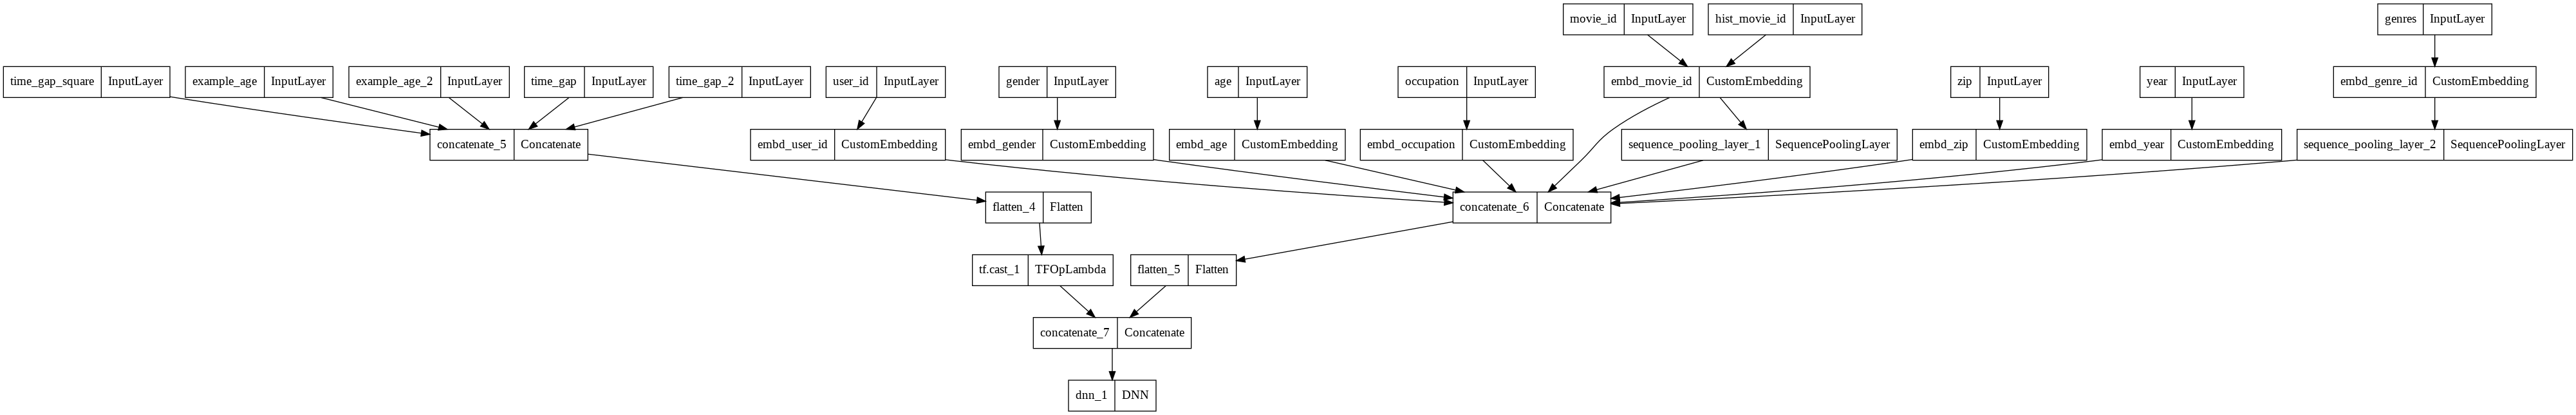

In [ ]:
plot_model(rank_model)

In [37]:
rank_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=binary_crossentropy)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='./rank_checkpoint/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
history = rank_model.fit(rank_train, rank_train_label,
                    batch_size=BATCH_SIZE*8, 
                    epochs=NEPOCH,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stop,checkpoint])

Epoch 1/50
284/284 [==============================] - 47s 157ms/step - loss: 0.5225 - val_loss: 0.2282
Epoch 2/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4600 - val_loss: 0.2243
Epoch 3/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4552 - val_loss: 0.2122
Epoch 4/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4447 - val_loss: 0.2037
Epoch 5/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4356 - val_loss: 0.1895
Epoch 6/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4230 - val_loss: 0.1756
Epoch 7/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4136 - val_loss: 0.1693
Epoch 8/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4082 - val_loss: 0.1642
Epoch 9/50
284/284 [==============================] - 44s 155ms/step - loss: 0.4045 - val_loss: 0.1603
Epoch 10/50
284/284 [==============================] - 44s 155ms/step - l

In [38]:
rank_model.load_weights('./rank_checkpoint/')

In [39]:
del rank_train
gc.collect()

7460

In [40]:
pred = rank_model.predict(rank_test, batch_size=BATCH_SIZE)

In [41]:
pred_df = pd.DataFrame(columns=['user_id','movie_id','pred'])
pred_df['user_id'] = rank_test['user_id']
pred_df['movie_id'] = rank_test['movie_id']
pred_df['pred'] = pred

pred_df = pred_df.sort_values(by=['user_id','pred'], ascending=False).reset_index(drop=True)
pred_df = pred_df.groupby('user_id')['movie_id'].apply(list).reset_index()

In [42]:
test_label_df = pd.DataFrame(columns=['user_id','label'])
test_label_df['user_id'] = match_test['user_id']
test_label_df['label'] = match_test_label.tolist()

In [43]:
test_label_df = pd.merge(test_label_df, pred_df, on=['user_id'], how='left')

In [44]:
map_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.02401748265531378

In [45]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=10)

0.06531456953642384

In [46]:
recall_at_k(test_label_df['label'], test_label_df['movie_id'], k=100)

0.4115728476821192